# **Reducing APF Data Tutorial**
By Zoe Ko

## About this tutorial

This tutorial is intended to show the progression of APF 1D data products. Begin with the reduced 1D spectra and follow four steps to reduce the data:
* Deblaze and normalize the data by dividing out the echelle blaze function
* Transform the wavelength solution of the data to constant RV space
* Download a corresponding synthetic or empirical spectrum and transform its wavelength solution to constant RV space
* Run a chi-squared test on the data and the empirical spectrum to determine doppler shift
* Shift the data to be in the rest frame


## About the data

The APF data can be downloaded from the Breakthrough Listen database, which can be found through the [Breakthrough Listen webpage](https://seti.berkeley.edu/listen/data.html). The solar flux spectrum can be found from [NSO](https://drive.google.com/file/d/12ByZSN1k6MOXBqOO-6Dpqrp1HvHr8b6z/view?usp=sharing).

In [4]:
from astropy.io import fits
import matplotlib.pylab as plt
import numpy as np
import scipy.interpolate
from scipy.interpolate import splev, splrep

In [5]:
from __future__ import print_function
import numpy as np
from astropy.io import fits
from scipy.optimize import least_squares
from scipy.special import expit
from scipy.stats import sigmaclip

from specmatchemp import spectrum
from specmatchemp.utils import utils


def shift(targ, ref, store=None, lowfilter=20):
    """Shifts the given spectrum by placing it on the same wavelength
    scale as the specified reference spectrum, then solves for shifts
    between the two spectra through cross-correlation.
    Args:
        targ (Spectrum): Target spectrum
        ref (Spectrum): Reference spectrum
        store (optional [file or dict]): h5 file or dict to record
            diagnostic data.
    Returns:
        shifted (Spectrum): Adjusted and flattened spectrum
    """
    s = np.copy(targ.s)
    serr = np.copy(targ.serr)
    w = np.copy(targ.w)
    mask = np.copy(targ.mask)
    if s.ndim == 1:
        s = np.array([s])
        serr = np.array([serr])
        w = np.array([w])
        mask = np.array([mask])

    ref = _extend_ref(ref, w[0, 0], w[-1, -1])

    # normalize each order of the target spectrum by dividing by the
    # 95th percentile
    percen_order = np.nanpercentile(s, 95, axis=1)
    s /= percen_order.reshape(-1, 1)

    # create empty 2d arrays to store each order
    s_shifted = np.asarray([[]])
    serr_shifted = np.asarray([[]])
    mask_shifted = np.asarray([[]])
    ws = np.asarray([[]])

    # create lists to store diagnostic data
    lag_data = []
    center_pix_data = []
    fit_data = []

    # length of each section in pixels
    section_length = 500

    if store is not None:
        store['num_orders'] = s.shape[0]

    # Containers for tempoerary holding of data
    s_rescaled = []
    serr_rescaled = []
    m_rescaled = []
    start_idxs = []

    # Fixed number of sections across every order
    num_sections = int(s.shape[1] / section_length) + 1

    # shift each order
    for i in range(s.shape[0]):
        ww = w[i]
        ss = s[i]
        sserr = serr[i]
        mm = mask[i]

        # clip ends off each order
        cliplen = 15
        ww = ww[cliplen:-cliplen]
        ss = ss[cliplen:-cliplen]
        sserr = sserr[cliplen:-cliplen]
        mm = mm[cliplen:-cliplen]

        # clip obvious noise
        clip = np.asarray([True if sp < 1.2 else False for sp in ss])
        ss = ss[clip]
        sserr = sserr[clip]
        mm = mm[clip]
        ww = ww[clip]

        # get the reference spectrum in the same range as the target range
        w_min = ww[0]
        w_max = ww[-1]

        in_range = np.asarray([True if wr > w_min and wr < w_max else False
            for wr in ref.w])
        start_idxs.append(np.argmax(in_range))
        w_ref_c = ref.w[in_range]
        s_ref_c = ref.s[in_range]
        m_ref_c = ref.mask[in_range]

        # place the target spectrum on the same wavelength scale
        ss, sserr, mm = rescale_w(ss, sserr, ww, mm, w_ref_c)

        s_rescaled.append(ss)
        serr_rescaled.append(sserr)
        m_rescaled.append(mm)

        # true section length
        l_sect = int(len(ss) / num_sections)

        lags = np.empty(num_sections)
        center_pix = np.empty(num_sections)

        if store is not None:
            key = "order_{0:d}/num_sections".format(i)
            store[key] = num_sections

        for j in range(num_sections):
            # Get indices for section
            idx_min = j * l_sect
            idx_max = (j+1) * l_sect
            center_pix[j] = (j + 1/2)*l_sect

            ss_sect = ss[idx_min:idx_max]
            mm_sect = mm[idx_min:idx_max]
            s_ref_sect = s_ref_c[idx_min:idx_max]
            m_ref_sect = m_ref_c[idx_min:idx_max]

            # Don't use segments which have too many nans
            if len(ss_sect[mm_sect]) < (l_sect / 2) or \
                    len(s_ref_sect[m_ref_sect]) < (l_sect / 2):
                lag = np.nan
                lag_arr = []
                xcorr = []
            else:
                # get the shifts in pixel number
                lag, lag_arr, xcorr = solve_for_shifts(ss_sect, mm_sect,
                                                       s_ref_sect, m_ref_sect,
                                                       lowfilter=lowfilter)
            # Save results
            lags[j] = lag
            if store is not None:
                key = "order_{0:d}/sect_{1:d}/".format(i, j)
                store[key+"xcorr"] = xcorr
                store[key+"lag_arr"] = lag_arr

        # Save lag data
        lag_data.append(lags)
        center_pix_data.append(center_pix)

    lag_data = np.asarray(lag_data)
    # Compute sigma-clipped mean lags for each segment, if there are multiple
    # orders
    if s.shape[0] > 1:
        clip = 2
        for j in range(lag_data.shape[1]):
            lag_order = lag_data[:, j]
            lag_order = lag_order[~np.isnan(lag_order)]
            clipped, crit_low, crit_high = sigmaclip(lag_order, low=clip,
                                                     high=clip)

            mean_lag = np.nanmean(clipped)

            # Replace values outside the critical range and nans with mean_lag
            for i in range(lag_data.shape[0]):
                curr = lag_data[i, j]
                lag_data[i, j] = curr if curr > crit_low and curr < crit_high \
                    else mean_lag
    else:
        for j in range(lag_data.shape[1]):
            curr = lag_data[0, j]
            if j == 0:
                lag_data[0, j] = lag_data[0, j + 1] if np.isnan(curr) else curr
            elif j == (lag_data.shape[1] - 1):
                lag_data[0, j] = lag_data[0, j - 1] if np.isnan(curr) else curr
            else:
                lag_data[0, j] = np.nanmean([lag_data[0, j - 1],
                    lag_data[0, j + 1]]) if np.isnan(curr) else curr

    for i in range(s.shape[0]):
        # Restore data from previous loop
        ss = s_rescaled[i]
        sserr = serr_rescaled[i]
        mm = m_rescaled[i]
        start_idx = start_idxs[i]

        lags = lag_data[i]
        center_pix = center_pix_data[i]

        # use robust least squares to fit a line to the shifts
        # (Cauchy loss function)
        p_guess = np.array([0, 0])
        fit_res = least_squares(_linear_fit_residuals, p_guess,
                                args=(center_pix, lags), loss='cauchy')
        fit = fit_res.x
        pix_arr = np.arange(0, len(ss))
        pix_shifted = pix_arr - fit[1] - pix_arr*fit[0]

        # don't read past the wavelength array
        pix_min = max(int(pix_shifted[0]), 0)
        pix_max = min(int(pix_shifted[-1]), len(ref.w)-start_idx)

        # new pixel array
        new_pix = np.arange(pix_min, pix_max)
        # new wavelength array
        w_ref_c = ref.w[start_idx+pix_min:start_idx+pix_max]

        # interpolate the spectrum back onto the reference spectrum
        ss_shifted = np.interp(new_pix, pix_shifted, ss)
        sserr_shifted = np.interp(new_pix, pix_shifted, sserr)
        mm_shifted = np.interp(new_pix, pix_shifted, mm)

        # append to array
        s_shifted = np.append(s_shifted, ss_shifted)
        serr_shifted = np.append(serr_shifted, sserr_shifted)
        mask_shifted = np.append(mask_shifted, mm_shifted)
        ws = np.append(ws, w_ref_c)

        # save diagnostic data
        fitted = fit[0] * center_pix + fit[1]
        fit_data.append(np.array(fitted))

    # save diagnostic data
    if store is not None:
        # convert jagged array to rectangular one
        lengths = []
        for l in lag_data:
            lengths.append(len(l))
        ml = max(lengths)

        lag_data = [utils.extend_array(l, ml) for l in lag_data]
        center_pix_data = [utils.extend_array(l, ml) for l in center_pix_data]
        fit_data = [utils.extend_array(l, ml) for l in fit_data]

        store['lag'] = np.asarray(lag_data)
        store['center_pix'] = np.asarray(center_pix_data)
        store['fit'] = np.asarray(fit_data)

    # flatten spectrum
    w_min = ws[0]
    w_max = ws[-1]
    in_range = np.asarray([True if wr > w_min and wr < w_max
                           else False for wr in ref.w])
    w_ref_trunc = ref.w[in_range]

    w_flat, s_flat, serr_flat, mask_flat = \
        flatten(ws, s_shifted, serr_shifted, mask_shifted, w_ref=w_ref_trunc)

    return spectrum.Spectrum(w_flat, s_flat, serr_flat, name=targ.name,
                             mask=mask_flat, header=targ.header,
                             attrs=targ.attrs)


def _isclose(a, b, abs_tol=1e-6):
    """Small helper function to determine if two floats are close.
    Only accepts absolute tolerances.
    """
    return abs(a-b) <= abs_tol


def _fill_nans(s, fill):
    """Replaces nans with the provided fill value
    """
    s[np.isnan(s)] = fill

    return s


def _linear_fit_residuals(p, x, y):
    """Calculates residuals for a linear fit
    """
    return p[0]*x + p[1] - y


def _extend_ref(ref, min_w, max_w):
    """Extends the reference spectrum to the given limits, assuming a constant
    delta log-lambda scale.
    Args:
        ref (spectrum.Spectrum): Reference spectrum
        min_w, max_w (float): Wavelength limts
    """
    # Delta log-lambda
    w = ref.w
    dw = np.median(np.log10(w[1:]) - np.log10(w[:-1]))

    if min_w < w[0]:
        num_points = int((np.log10(w[0]) - np.log10(min_w))/dw)
        left = np.logspace(np.log10(w[0]), np.log10(min_w), num_points,
                           base=10.0)[1:]
        # Don't forget to reverse left
        w = np.concatenate((left[::-1], w))

    if max_w > w[-1]:
        num_points = int((np.log10(max_w) - np.log10(w[-1]))/dw)
        right = np.logspace(np.log10(w[-1]), np.log10(max_w), num_points,
                            base=10.0)[1:]
        w = np.concatenate((w, right))

    if len(w) != len(ref.w):
        ref = ref.extend(w)

    return ref


def flatten(w, s, serr=None, mask=None, w_ref=None, wavlim=None):
    """Flattens a given 2-D spectrum into a 1-D array.
    Merges overlapped points by taking the mean.
    If w_ref is given, fills values that don't occur in the 2D spectrum
    with np.nan
    Args:
        w (np.ndarray): Wavelength array
        s (np.ndarray): Spectrum
        serr (np.ndarray, optional): Uncertainty in spectrum
        mask (np.ndarray, optional): Boolean mask
        w_ref (np.nadarray, optional): Reference, 1-D wavelength array
        wavlim (2-element iterable, optional): Wavelength limits
    Returns:
        w, s, serr: Wavelength, spectrum and uncertainty in spectrum
    """
    if np.shape(w) != np.shape(s):
        raise ValueError("Error: w, s not the same shape.")
    if serr is not None and np.shape(w) != np.shape(serr):
        raise ValueError("Error: w, serr not the same shape.")

    # no need to do anything if spectrum is already flat
    if np.shape(w)[0] == 1:
        w_flattened = w[0]
        s_flattened = s[0]
        serr_flattened = None if serr is None else serr[0]
        mask_flattened = None if mask is None else mask[0]
        return w_flattened, s_flattened, serr_flattened, mask_flattened

    if w_ref is None:
        w_flattened = np.unique(w)
    else:
        w_flattened = w_ref

    # create new arrays to contain spectrum
    s_flattened = np.empty_like(w_flattened)
    serr_flattened = None if serr is None else np.empty_like(w_flattened)
    mask_flattened = None if mask is None else np.empty_like(w_flattened)
    idx_max = len(w)-1
    c_idx = 0
    n_idx = 0

    for i, wl in enumerate(w_ref):
        while w[c_idx] < wl and c_idx < idx_max and not _isclose(w[c_idx], wl):
            c_idx += 1

        if c_idx >= idx_max:
            s_flattened[i] = np.nan
            if serr is not None:
                serr_flattened[i] = np.nan
            if mask is not None:
                mask_flattened[i] = False
            continue

        overlap = False
        if _isclose(w[c_idx], wl):
            # scan for overlapping region
            while n_idx < idx_max:
                n_idx += 1
                if c_idx == n_idx:
                    continue
                elif _isclose(w[n_idx], wl):
                    overlap = True
                    break
                elif w[n_idx] > w[c_idx] and w[n_idx] < w[n_idx-1]:
                    # lock at start of new order
                    n_idx -= 1
                    break
            if overlap:
                s_flattened[i] = (s[c_idx]+s[n_idx])/2
                if serr is not None:
                    serr_flattened[i] = (serr[c_idx]+serr[n_idx])/2
                if mask is not None:
                    mask_flattened[i] = bool(mask[c_idx]) & bool(mask[n_idx])
            else:
                s_flattened[i] = s[c_idx]
                if serr is not None:
                    serr_flattened[i] = serr[c_idx]
                if mask is not None:
                    mask_flattened[i] = mask[c_idx]
            c_idx += 1
        else:
            s_flattened[i] = np.nan
            if serr is not None:
                serr_flattened[i] = np.nan
            if mask is not None:
                mask_flattened[i] = False

    return w_flattened, s_flattened, serr_flattened, mask_flattened


def solve_for_shifts(s, mask, s_ref, mask_ref, lowfilter=20):
    """
    Solve for the pixel shifts required to align two spectra that are on the
    same wavelength scale.
    Correlates the two spectra, then fits a quadratic to the peak in order to
    solve for sub-pixel shifts.
    Args:
        s: The target spectrum array
        mask: Mask array for the target spectrum
        s_ref: The reference spectrum
        mask_ref: Mask array for the reference spectrum
    Returns:
        The pixel shift, the lag and correlation data
    """
    # set masked values to nan
    s = s.copy()
    s[~mask] = np.nan
    s_ref = s_ref.copy()
    s_ref[~mask_ref] = np.nan

    # find the mean of the two spectra
    smean = np.nanmean(s)
    srefmean = np.nanmean(s_ref)
    # fill nans with mean value so they contribute nothing to correlation
    s = _fill_nans(s, smean)
    s_ref = _fill_nans(s_ref, srefmean)

    # # perform correlation
    # xcorr = np.correlate(s-smean, s_ref-srefmean, mode='full')
    # xcorr = np.nan_to_num(xcorr)
    # max_corr = np.argmax(xcorr)

    # # number of pixels
    # npix = xcorr.shape[0]
    # lag_arr = np.arange(-(npix-1)/2, (npix+1)/2, 1)

    # perform correlation
    xcorr = correlate(s-smean, s_ref-srefmean, lowfilter=lowfilter)
    max_corr = np.argmax(xcorr)
    npix = len(xcorr)
    lag_arr = np.arange(-npix/2+1, npix/2+1, 1)

    # select points around the peak and fit a quadratic
    lag_peaks = lag_arr[max_corr-1:max_corr+2]
    xcorr_peaks = xcorr[max_corr-1:max_corr+2]

    p = np.polyfit(lag_peaks, xcorr_peaks, 2)
    # peak is simply -p[1]/2p[0]
    lag = -p[1] / (2*p[0])

    return lag, lag_arr, xcorr


def correlate(a, v, lowfilter=0):
    """Custom function to perform 1-dimensional cross-correlation
    Args:
        a (np.ndarray): Input sequence
        v (np.ndarray): Input sequence
        lowfilter (int): Filter out components with wavelength above this
            number of pixels
    Returns:
        np.ndarray: Symmetric cross-correlation array
    """
    # Zero pad arrays to double length, rounded to nearest power of two
    # This is necessary to avoid effects from circular convolution
    l = max(len(a), len(v))
    # Add 1 in the exponent for doubling the length
    # Add another for integer rounding
    padded_length = 2**int(np.log2(l) + 1 + 1)
    a_padded = np.zeros(padded_length)
    a_padded[:len(a)] = a
    v_padded = np.zeros(padded_length)
    v_padded[:len(v)] = v

    # Perform fast Fourier transforms of the input sequences
    a_f = np.fft.rfft(a_padded)
    v_f = np.fft.rfft(v_padded)

    cutoff = int(padded_length/lowfilter)
    # Use a sigmoid filter
    pix = np.arange(len(a_f))
    b = expit(0.01 * (pix - cutoff))

    # Perform low frequency filtering
    a_f *= b
    v_f *= b

    # Use correlation theorem to perform a fast cross-correlation
    xcorr = np.fft.irfft(np.conj(a_f) * v_f)

    # Final correlation array is by convention reversed and reorderd
    xcorr_rearranged = np.empty(len(xcorr))
    xcorr_rearranged[:int(len(xcorr)/2)] = xcorr[int(len(xcorr)/2):]
    xcorr_rearranged[int(len(xcorr)/2):] = xcorr[:int(len(xcorr)/2)]
    xcorr_rearranged = xcorr_rearranged[::-1]

    return xcorr_rearranged


def rescale_w(s, serr, w, m, w_ref):
    """
    Place the given spectrum on the wavelength scale specified by w_ref
    Args:
        s, serr, w: The spectrum and original wavelength scale.
        w_ref: The desired wavelength scale
    Returns:
        The spectrum and associated error on the desired scale.
    """
    snew = np.interp(w_ref, w, s)
    serrnew = np.interp(w_ref, w, serr)
    mnew = np.interp(w_ref, w, m).astype(bool)

    return snew, serrnew, mnew


def shift_data_to_hdu(shift_data):
    """Saves the shift data to a BinTableHDU.
    Args:
        shift_data (dict): Shift data output from shift()
    """
    shift_data = shift_data.copy()
    col_list = []
    num_orders = shift_data.pop('num_orders')
    col_list.append(fits.Column(name='num_orders', format='J',
                                array=[num_orders]))

    num_sects = []
    for i in range(num_orders):
        num_sects.append(shift_data.pop('order_{0:d}/num_sections'
                                        .format(i)))
    col_list.append(fits.Column(name='num_sects', format='J',
                                array=num_sects))
    n_sec = max(num_sects)

    for k in ['center_pix', 'lag', 'fit']:
        col_list.append(fits.Column(name=k,
                        format='{0:d}E'.format(n_sec),
                        array=shift_data.pop(k)))

    # Save individual fit data
    for k in shift_data.keys():
        if np.ndim(shift_data[k]) == 0:
            arr = [shift_data[k]]
        else:
            arr = shift_data[k]
        col_list.append(fits.Column(name=k, format='D',
                                    array=arr))

    shift_hdu = fits.BinTableHDU.from_columns(col_list)
    shift_hdu.name = 'SHIFTDATA'

    return shift_hdu


def save_shift_to_fits(outpath, shifted, unshifted, shift_data, clobber=False):
    """Saves the complete shift data to a FITS file.
    Args:
        outpath (str): Path to save output file
        shifted (Spectrum): Shifted spectrum
        unshifted (HiresSpectrum): Raw spectrum
        shift_data (dict): Shift data
        clobber (bool): Overwrite existing file at destination
    """
    # Create primary HDU
    prihdu = fits.PrimaryHDU(header=shifted.header)
    # Save shifted spectrum
    shifted_hdu = shifted.to_hdu()

    # Save unshifted spectrum
    unshifted_hdus = unshifted.to_hdulist(primary=False)

    # Save shift data
    shift_data_hdu = shift_data_to_hdu(shift_data)

    hdulist = fits.HDUList([prihdu, shifted_hdu, shift_data_hdu] +
                           unshifted_hdus)

    hdulist.writeto(outpath, overwrite=clobber)

## Read in APF Data

This tutorial uses 10 CVn (HIP62207), an F type star. It takes spectra from order 38, which includes wavlengths from approximately 5380 to 5460 Angstroms.

In [6]:
star = 'HIP62207'
APF_wavelength_path = '/mnt_home/zoek/code/APF-BL-DAP/APFTutorial/apf_wav.fits'
APF_flux_path = '/datag/blpd0/datax/apf/rarj.224.fits'

wl_file = fits.open(APF_wavelength_path)
fl_file = fits.open(APF_flux_path)
wl_image = wl_file[0].data
fl_image = fl_file[0].data

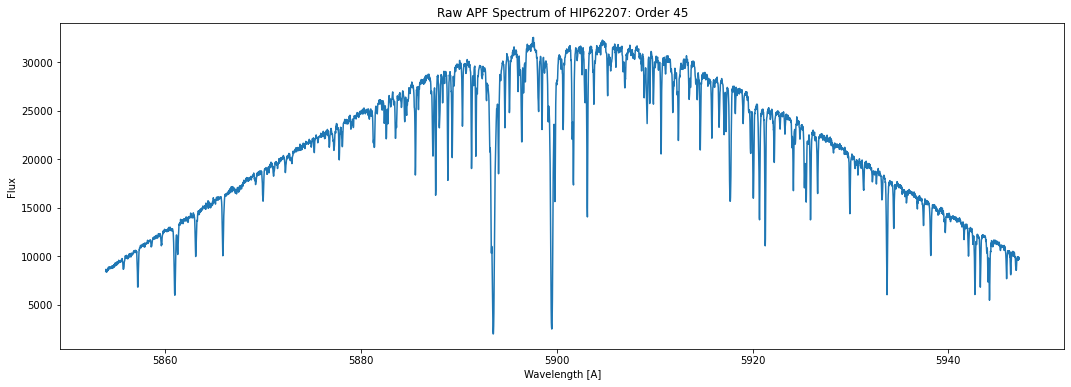

In [7]:
plt.rcParams["figure.figsize"] = (18,6)

order = 45
wl = wl_image[order]
flux = fl_image[order][:-1]
plt.plot(wl,flux)

plt.title('Raw APF Spectrum of ' + star + ': Order ' + str(order))
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.show()

## Dividing out the Echelle Blaze Function

Divide the data into bins of 100 pixels. Find the flux value in the 95th percentile within each bin and plot these flux values onto the wavelength values. Divide the APF flux spectrum by the fit of the 95th percentile flux values.

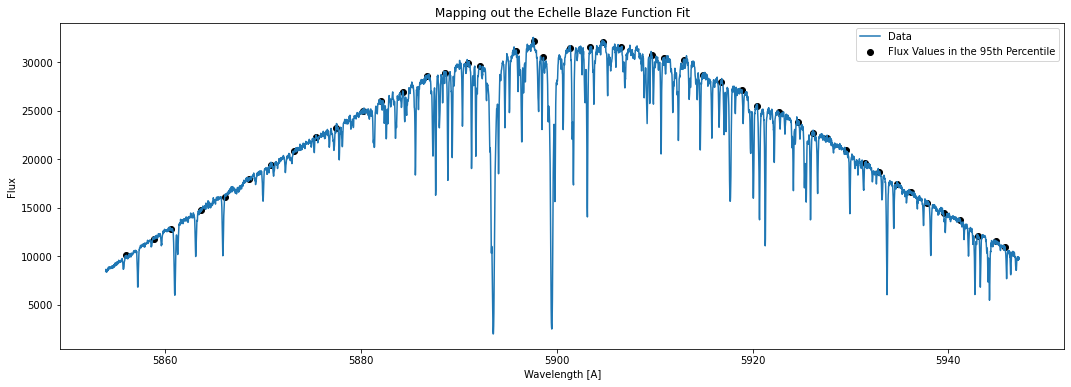

In [8]:
bin = 100

# this list will contain the indices corresponding to each of the 95th percentile flux values in each bin
indices = []

for i in np.arange((len(wl) - (bin)), step = bin):
    flux_values = []
    for j in np.arange(i, i + bin, step = 1):
        value = flux[j]
        flux_values = np.append(flux_values, value)
    # find the 95th percentile flux value: we use 95 to get the maximum flux value in general 
    # but avoid issues with cosmic rays and other emission lines
    flux_in_bin = np.percentile(flux_values, 95)
    # find the closest value in the flux array to the 95th percentile value
    absolute_difference_function = lambda list_value : abs(list_value - flux_in_bin)
    flux_in_bin = min(flux_values.tolist(), key=absolute_difference_function)
    index_in_bin = flux_values.tolist().index(flux_in_bin)
    index = i + index_in_bin
    indices = np.append(indices, index)

# these lists will contain the wavlength and flux values at each index in 'indices'
wl_values = []
fl_values = []

for index in indices:
    ind = int(index)
    wl_values = np.append(wl_values, wl[ind])
    fl_values = np.append(fl_values, flux[ind])
    
plt.plot(wl, flux, label = 'Data')
plt.scatter(wl_values, fl_values, color = 'black', label = 'Flux Values in the 95th Percentile')
plt.title('Mapping out the Echelle Blaze Function Fit')
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.legend()
plt.show()

Plot fl_values onto wl_values so that the length of the arrays match that of the APF spectrum. Set s to 500000 to smooth the fit.

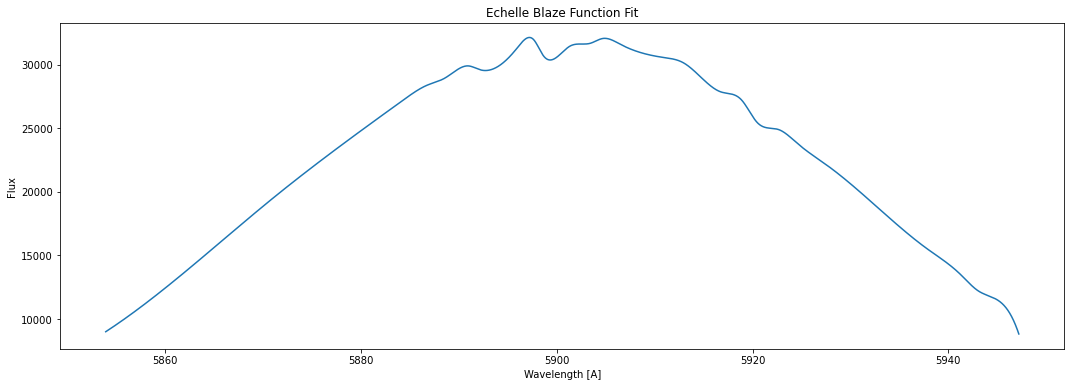

In [9]:
spl = splrep(wl_values, fl_values, s = 500000)
flux_fit = splev(wl, spl)
plt.plot(wl, flux_fit)
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.title('Echelle Blaze Function Fit')
plt.show()

Divide out the fit from the data.

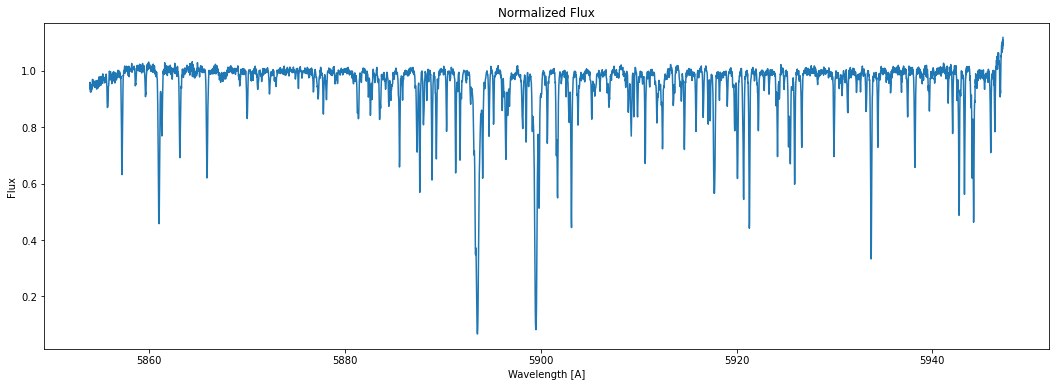

In [10]:
first_normalized_flux = flux / flux_fit
plt.plot(wl, first_normalized_flux)
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.title('Normalized Flux')
plt.show()

However, this spectra is not well normalized because the values in each bin were drawn from the 95th percentile. Do another normalization by finding the 98th percentile of the data and dividing the data by that value to ensure that the continuum is at 1.0.

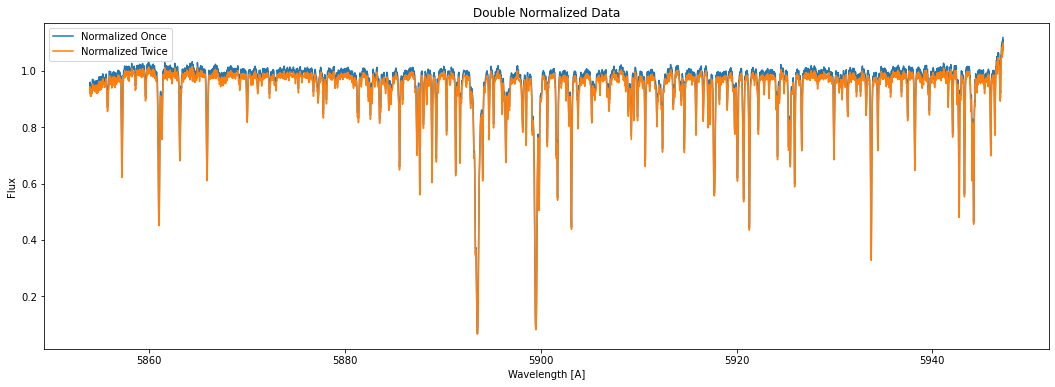

In [11]:
flux98 = np.percentile(first_normalized_flux, 98)
normalized_flux = first_normalized_flux / flux98

plt.plot(wl, first_normalized_flux, label = 'Normalized Once')
plt.plot(wl, normalized_flux, label = 'Normalized Twice')
plt.legend()
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.title('Double Normalized Data')
plt.show()

Now we have a normalized spectrum with its continuum at 1.0.

## Regriding the Wavelength Grid to be in Constant RV Space
Plot the normalized flux values onto the original wavelength grid, create a new wavelength grid that is log lambda spaced, and then interpolate onto the new wavelength grid. This will create a spectrum that is in constant RV space, which will allow for a straightforward calculation of the Doppler shift.

In [30]:
# C = 299792.458 #km/s
# V = 1 #km/s
# def regrid(wl, normalized_flux):
#     f = scipy.interpolate.interp1d(wl, normalized_flux, kind='cubic')
#     new_wl = wl + (wl * V / C)
#     max_wl = max(wl) - 1
#     absolute_difference_function = lambda list_value : abs(list_value - max_wl)
#     w = min(new_wl.tolist(), key = absolute_difference_function)
#     max_index = new_wl.tolist().index(w)
#     return new_wl[:max_index], f(new_wl[:max_index])

In [31]:
# wl, flux = regrid(wl, normalized_flux)

Plot the new wavelength grid against flux values. This should look the same as before; however, the wavelengths are now velocity spaced.

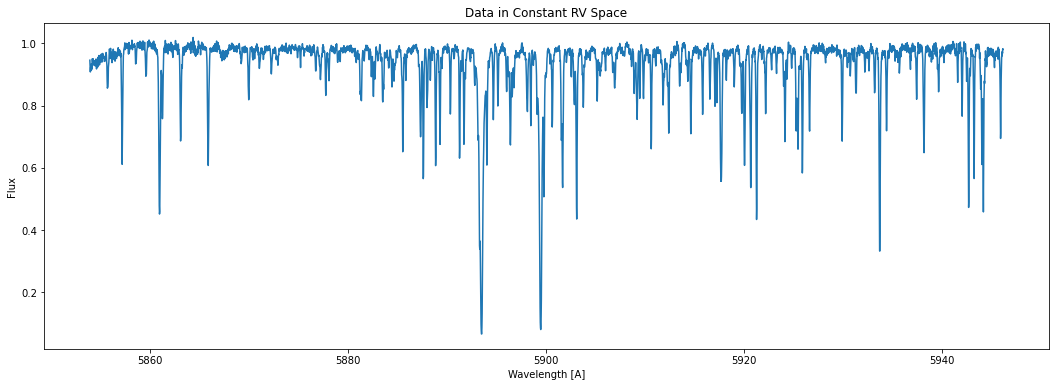

In [32]:
# plt.plot(wl, flux)
# plt.xlabel('Wavelength [A]')
# plt.ylabel('Flux')
# plt.title('Data in Constant RV Space')
# plt.show()

## Empirical Solar Spectrum
Read the empirical solar spectrum using astropy.io.fits. There are two arrays: one is the wavelength from around 3000 angstroms to 12,500 Angstroms, and the second is the corresponding flux array. Truncate it to match the wavelength range of the APF data. 

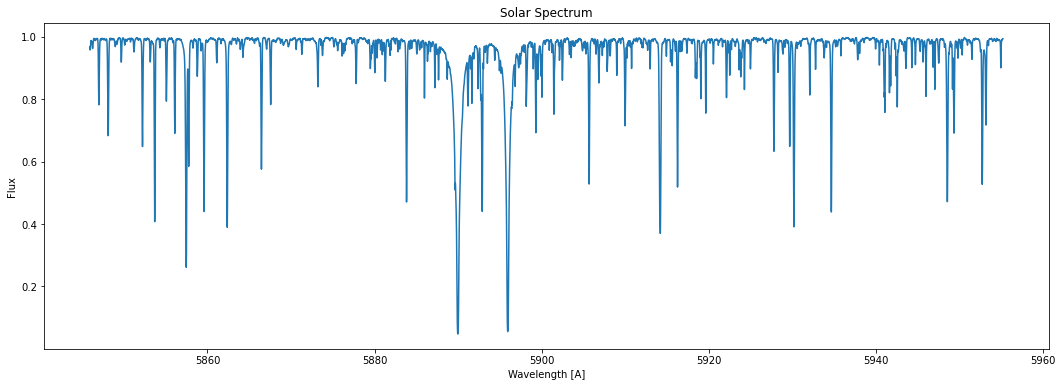

In [12]:
solar_spectrum_path = '/mnt_home/zoek/code/APF-BL-DAP/APFTutorial/nso.fits'

solar_spectrum = fits.open(solar_spectrum_path)
wl_temp = solar_spectrum[0].data
fl_temp = solar_spectrum[1].data

# wavelengths of APF data
min_wl = min(wl) - 8
absolute_difference_function = lambda list_value : abs(list_value - min_wl)
w = min(wl_temp.tolist(), key = absolute_difference_function)
min_index = wl_temp.tolist().index(w)

max_wl = max(wl) + 8
absolute_difference_function = lambda list_value : abs(list_value - max_wl)
w = min(wl_temp.tolist(), key = absolute_difference_function)
max_index = wl_temp.tolist().index(w)

wl_syn_temp = wl_temp[min_index:max_index]
fl_syn_temp = fl_temp[min_index:max_index]

plt.plot(wl_syn_temp, fl_syn_temp)
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.title('Solar Spectrum')
plt.show()

Regrid the synthetic spectrum to be log lambda spaced (contant velocity).

In [34]:
# wl_syn, fl_syn = regrid(wl_syn_temp, fl_syn_temp)

Plot the new wavelength grid against flux values. This should look the same as before; however, the wavelengths are now velocity spaced.

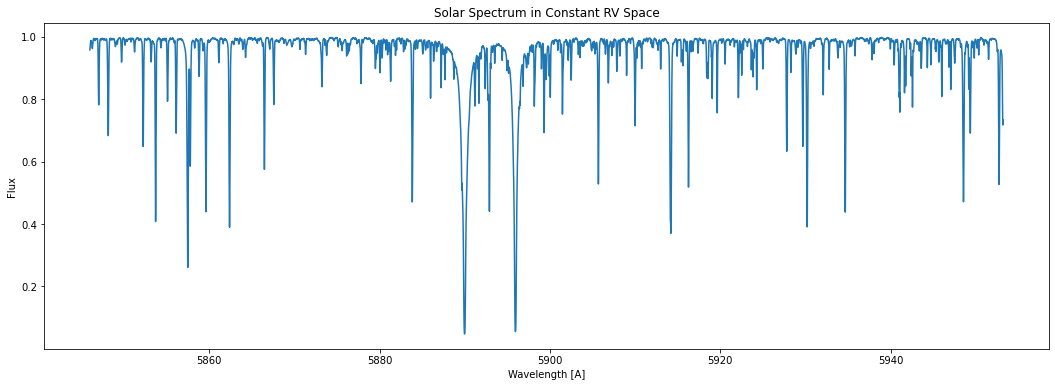

In [35]:
# plt.plot(wl_syn, fl_syn)
# plt.xlabel('Wavelength [A]')
# plt.ylabel('Flux')
# plt.title('Solar Spectrum in Constant RV Space')
# plt.show()

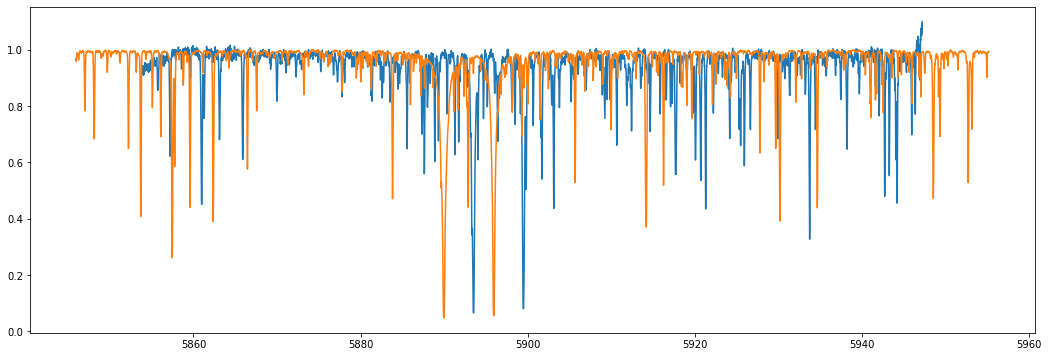

In [14]:
plt.plot(wl, normalized_flux)
plt.plot(wl_syn_temp, fl_syn_temp)
plt.show()



## Finding the velocity shift of the data from the empirical spectrum

In [36]:
def _extend_ref(w, min_w, max_w):
    """Extends the reference spectrum to the given limits, assuming a constant
    delta log-lambda scale.
    Args:
        w (array): Wavelength of Reference spectrum
        min_w, max_w (float): Wavelength limts
    """
    # Delta log-lambda
    dw = np.median(np.log10(w[1:]) - np.log10(w[:-1]))

    if min_w < w[0]:
        num_points = int((np.log10(w[0]) - np.log10(min_w))/dw)
        left = np.logspace(np.log10(w[0]), np.log10(min_w), num_points,
                           base=10.0)[1:]
        # Don't forget to reverse left
        w = np.concatenate((left[::-1], w))

    if max_w > w[-1]:
        num_points = int((np.log10(max_w) - np.log10(w[-1]))/dw)
        right = np.logspace(np.log10(w[-1]), np.log10(max_w), num_points,
                            base=10.0)[1:]
        w = np.concatenate((w, right))
        
    return w

#     if len(w) != len(ref.w):
#         ref = ref.extend(w)

#     return ref



new_w = _extend_ref(wl_syn_temp, min(wl), max(wl))

# plt.plot(wl_syn_temp[1:] - wl_syn_temp[:-1])
# plt.plot(wl[1:] - wl[:-1])


# plt.plot(wl)

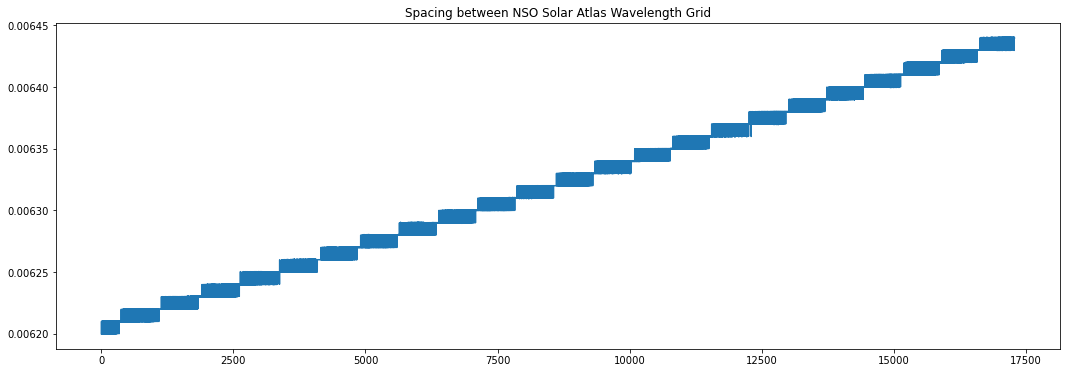

In [33]:
plt.plot(wl_syn_temp[1:] - wl_syn_temp[:-1])
plt.title('Spacing between NSO Solar Atlas Wavelength Grid')
plt.show()

# Spacing between pixels increases at greater wavelengths.

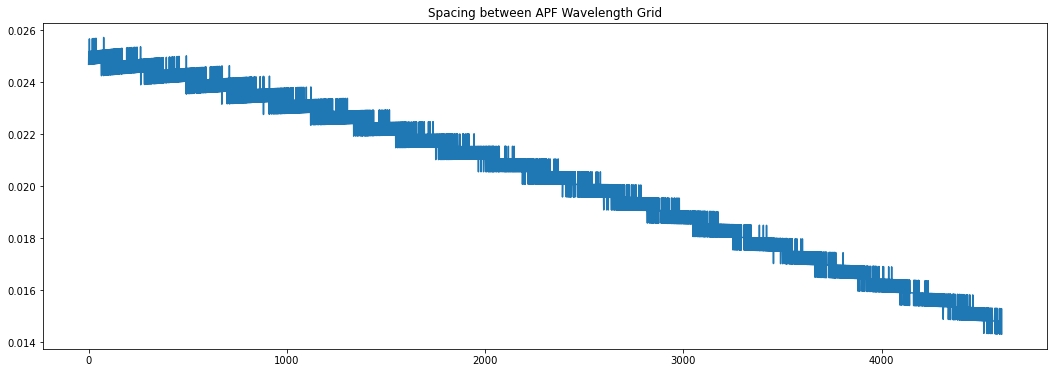

In [35]:
plt.plot(wl[1:] - wl[:-1])
plt.title('Spacing between APF Wavelength Grid')
plt.show()

# Spacing between pixels decreases at greater wavelengths.

In [ ]:
def rescale_w(s, serr, w, m, w_ref):
    """
    Place the given spectrum on the wavelength scale specified by w_ref
    Args:
        s, serr, w: The spectrum and original wavelength scale.
        w_ref: The desired wavelength scale
    Returns:
        The spectrum and associated error on the desired scale.
    """
    snew = np.interp(w_ref, w, s)
    serrnew = np.interp(w_ref, w, serr)
    mnew = np.interp(w_ref, w, m).astype(bool)

    return snew, serrnew, mnew

rescale_w()

First find the current offset of the APF spectrum and the empirical spectrum.

In [44]:
min_wl = min(wl)
absolute_difference_function = lambda list_value : abs(list_value - min_wl)
w = min(wl_syn.tolist(), key = absolute_difference_function)
index = wl_syn.tolist().index(w)

print('The first value of the APF data is located at pixel ' + str(index) + ' of the empirical spectrum.')

The first value of the APF data is located at pixel 1284 of the empirical spectrum.


Run a chi-squared test to determine the offset of the data and the empirical spectrum. The chi-squared test will scan the data against the synthetic spectrum: it will begin where the first pixels of each spectrum line up and end where the last pixels of each spectrum line up. The test will calculate the residual at each location. When the two spectra line up, the residual will be minimized, resulting in a minimum in the chi-squared plot. 

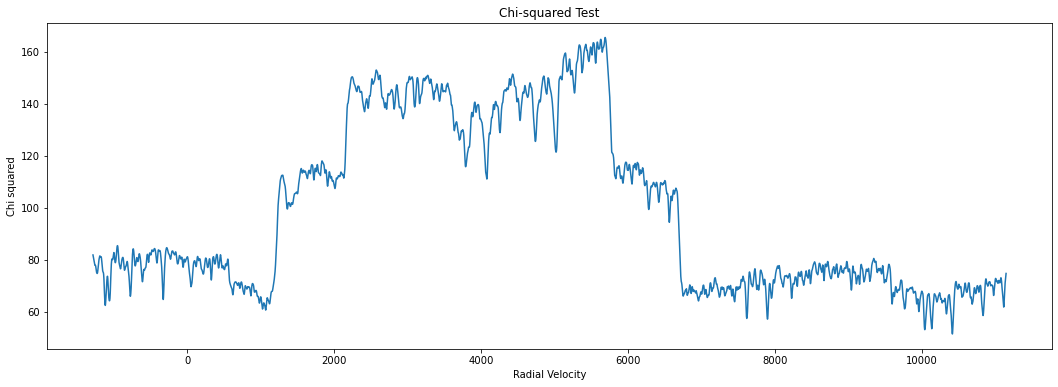

HIP62207 is traveling away from Earth at 10415 km/s. The APF spectrum needs to be blueshifted by 10415 pixels. (Shift to right.)


In [15]:
def chi(model, data):
    '''given two arrays of the same length,
    calculate chi squared'''
    return np.sum((data - model) ** 2)

chi_squared_values = []
indices = []

for i in np.arange(len(wl_syn) - len(wl)):
    syn_flux = fl_syn[i: i + len(wl)]
    chi_squared = chi(syn_flux, flux)
    chi_squared_values = np.append(chi_squared_values, chi_squared)
    indices = np.append(indices, i)
    
min_chi = min(chi_squared_values)
shifted_index = chi_squared_values.tolist().index(min_chi)

plt.plot(indices - index, chi_squared_values)
plt.xlabel('Radial Velocity')
plt.ylabel('Chi squared')
plt.title('Chi-squared Test')
plt.show()

if (shifted_index - index) < 0:
    shift = index - shifted_index
    print(star + ' is traveling toward Earth at ' + str(shift) + ' km/s. The APF spectrum needs to be redshifted by ' + str(shift) + ' pixels. (Shift to left.)')
    shift_dir = 'left'
else:
    shift = shifted_index - index
    print(star + ' is traveling away from Earth at ' + str(shift) + ' km/s. The APF spectrum needs to be blueshifted by ' + str(shift) + ' pixels. (Shift to right.)')
    shift_dir = 'right'

The minimum chi-squared value occurs where the residual between the data and the empirical spectrum is minimized, indicating a best fit. The noise around this minimum represent RV values where the data happens to fit better or worse with the empirical spectrum.

Make a plot of the unshifted APF spectrum against the empirical spectrum.

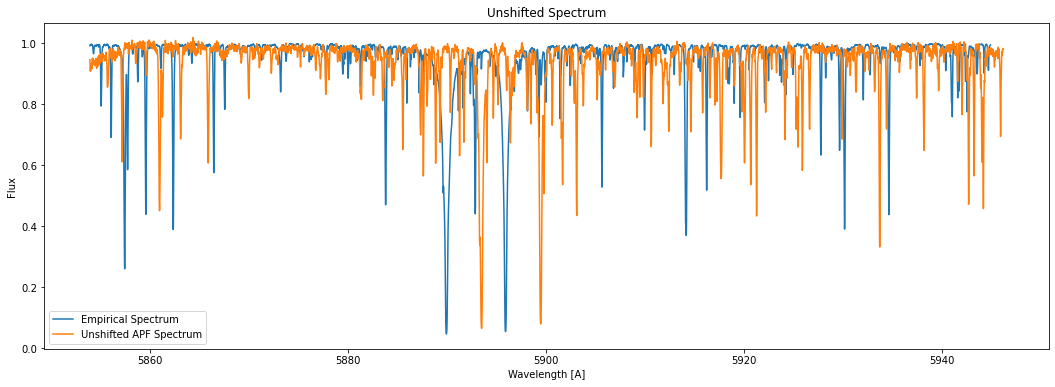

In [16]:
wl_syn_plot = wl_syn[index:-index]
fl_syn_plot = fl_syn[index:-index]

if shift_dir == 'left':
    shifted_wl = wl[:-shift]
    shifted_fl = flux[shift:]
else:
    shifted_wl = wl[shift:]
    shifted_fl = flux[:-shift]

plt.plot(wl_syn_plot, fl_syn_plot, label = 'Empirical Spectrum')
plt.plot(wl, flux, label = 'Unshifted APF Spectrum')

plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.title('Unshifted Spectrum')
plt.legend()
plt.show()

Zoom in to a smaller region of the plot to better visualize the offset between the data and the empirical spectrum.

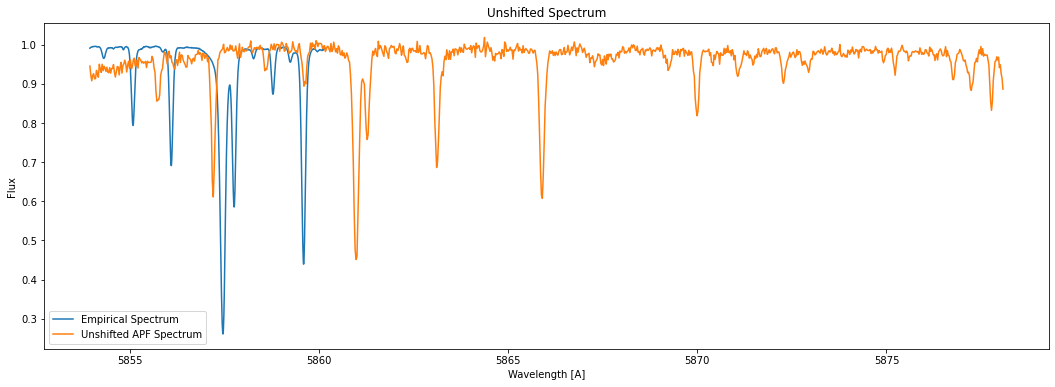

In [17]:
wl_syn_plot = wl_syn[index:-index]
fl_syn_plot = fl_syn[index:-index]

if shift_dir == 'left':
    shifted_wl = wl[:-shift]
    shifted_fl = flux[shift:]
else:
    shifted_wl = wl[shift:]
    shifted_fl = flux[:-shift]

plt.plot(wl_syn_plot[0:1000], fl_syn_plot[0:1000], label = 'Empirical Spectrum')
plt.plot(wl[0:1000], flux[0:1000], label = 'Unshifted APF Spectrum')

plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.title('Unshifted Spectrum')
plt.legend()
plt.show()

Plot the residuals.

In [18]:
residuals_unshifted = flux[len(wl_syn_plot)] - fl_syn_plot
plt.plot(wl_syn_plot, residuals_unshifted)
 
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.title('Residuals of Shifted APF Spectrum against Empirical Spectrum')
plt.show()

print('The average residual is ' + str(np.average(residuals_unshifted)))

IndexError: index 14400 is out of bounds for axis 0 with size 4537

Now make a plot of the shifted APF spectrum against the empirical spectrum. The data should line up with the empirical spectrum much better.

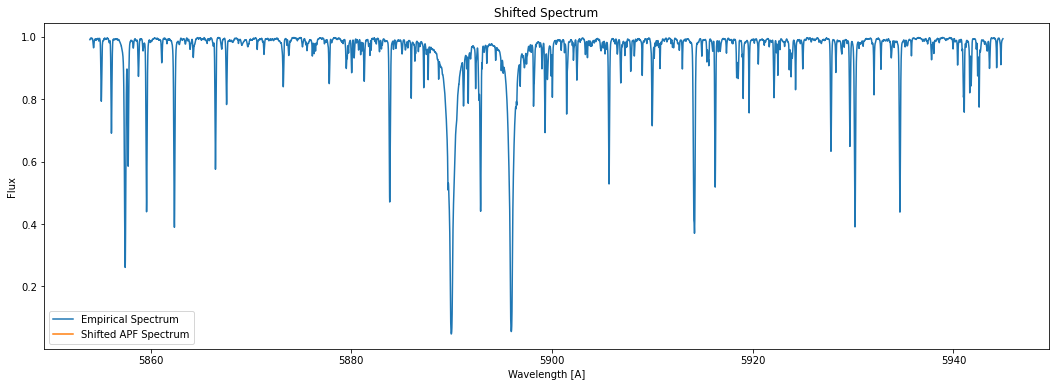

In [19]:
plt.plot(wl_syn_plot, fl_syn_plot, label = 'Empirical Spectrum')
plt.plot(shifted_wl, shifted_fl, label = 'Shifted APF Spectrum')

plt.title('Shifted Spectrum')
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.legend()
plt.show()

Zoom in to a smaller region of the plot to better visualize the difference.

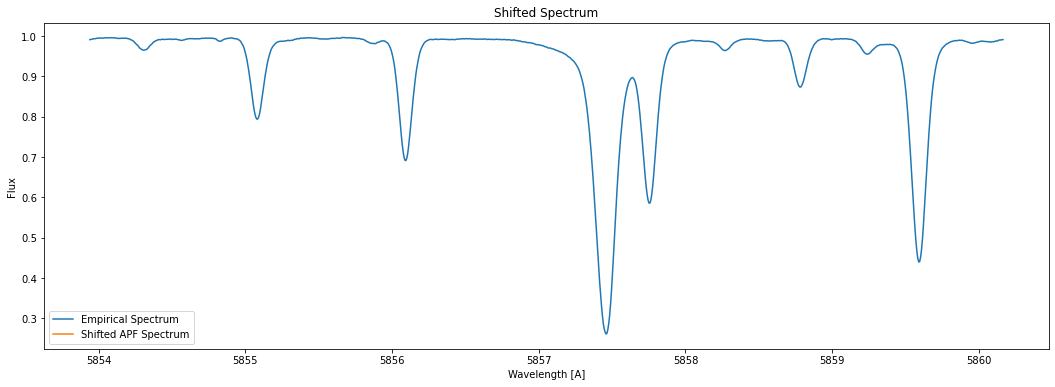

In [20]:
plt.plot(wl_syn_plot[0:1000], fl_syn_plot[0:1000], label = 'Empirical Spectrum')
plt.plot(shifted_wl[0:1000], shifted_fl[0:1000], label = 'Shifted APF Spectrum')

plt.title('Shifted Spectrum')
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.legend()
plt.show()

The residuals should be much lower.

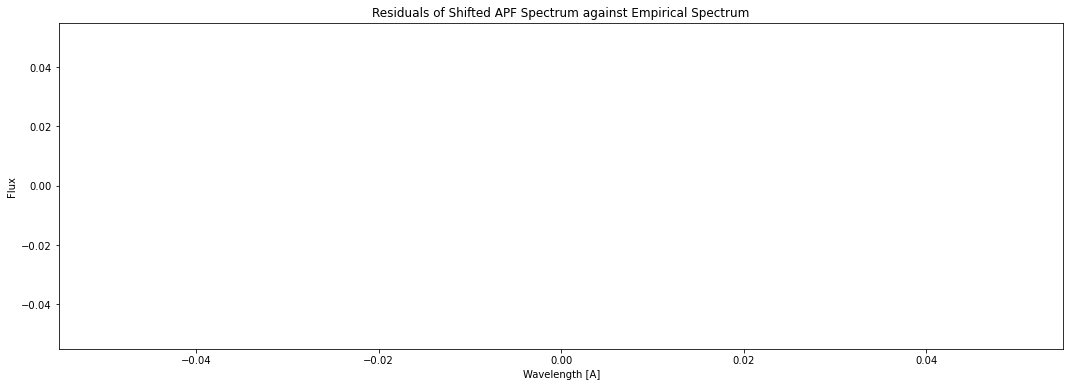

In [21]:
residuals_shifted = shifted_fl - fl_syn_plot[:len(shifted_wl)]
plt.plot(wl_syn_plot[:len(shifted_wl)], residuals_shifted)

plt.title('Residuals of Shifted APF Spectrum against Empirical Spectrum')
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.show()

## Final Product
Now we have a normalized, deblazed APF spectrum, shifted so that it is in its rest frame.

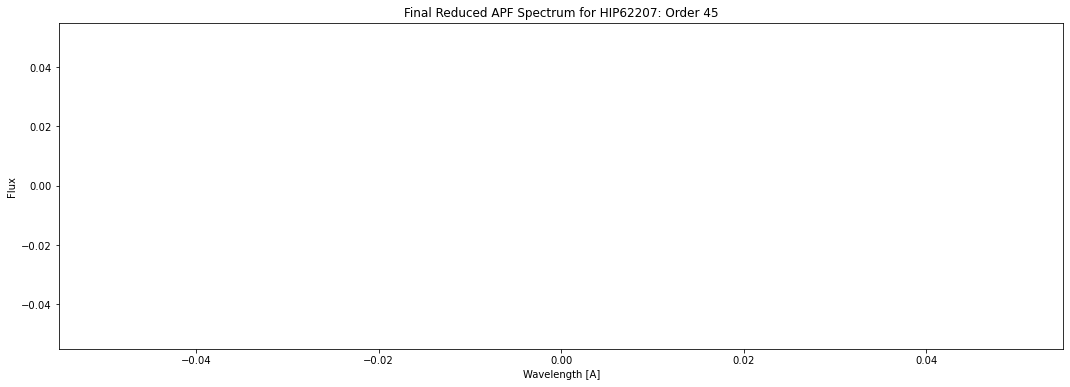

In [22]:
plt.plot(shifted_wl, shifted_fl)
plt.title('Final Reduced APF Spectrum for ' + star + ': Order ' + str(order))
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.show()